In [42]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
from scipy.ndimage import gaussian_filter1d

plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["f07167","219ebc","c767ac", "59a270", "ffba0a"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load data

In [30]:
min_z   = 0.01
max_z   = 5
delta_z = 0.05
zbins   = np.arange(min_z,max_z+delta_z,delta_z)
zbinsc  = zbins[:-1]+(zbins[1]-zbins[0])/2.


files = sorted(glob.glob('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20240408/Final/nz_Samp*.npy'))
X  = np.concatenate([np.load(f) for f in files]) / delta_z

colors2 =['C0', 'C1', 'C2', 'C3']

Likelihood  = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20240408/Final/LnLikelihood_Fiducial_all.npy')
max_like    = np.min(Likelihood[..., 0], axis = 0)
good        = np.abs(Likelihood[..., 0] - max_like) < stats.chi2.ppf(stats.norm.cdf(5), 8)/2

Z  = np.load('/project/chihway/dhayaa/DECADE/Wz/20240726_fiducial_Wz_600patch_urmask_CovMat.npy', allow_pickle = True)[()]
z = np.linspace(0.1, 2.1, 40 + 1)
z = (z[1:] + z[:-1])/2

dz1 = delta_z
dz3 = z[1] - z[0]

WZ SUBSELECTS 838 SAMPLES
0 0.3344060723718069 0.006901099298423754
0 0.3302841639882364 0.0068477759499710154
WZ SUBSELECTS 2124 SAMPLES
1 0.5049754398926517 0.007394940054068074
1 0.5100721574845417 0.007513061025545975
WZ SUBSELECTS 25 SAMPLES
2 0.7110906876147337 0.006934460120711559
2 0.7195244503644557 0.007530330490965063
WZ SUBSELECTS 13464 SAMPLES
3 0.9092244062107567 0.007818816451298971
3 0.9125838485099665 0.007934125040232198


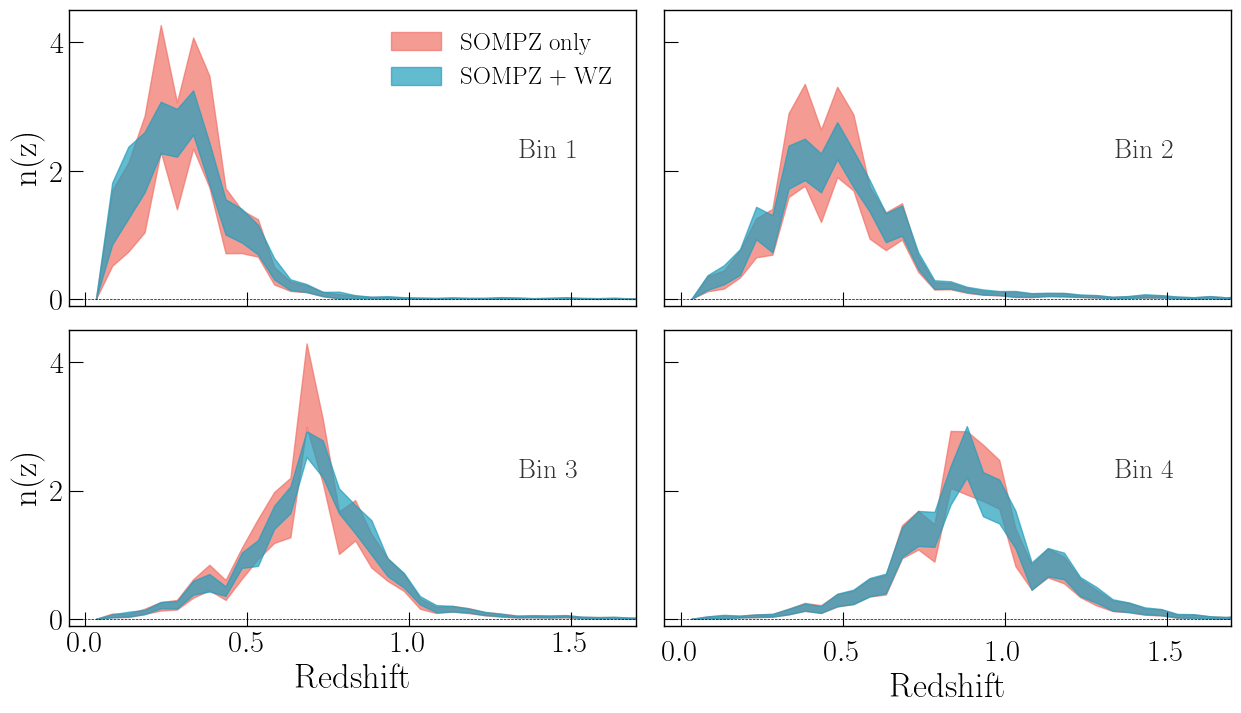

In [29]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (15,  8))
ax = ax.flatten()
plt.subplots_adjust(wspace = 0.05, hspace = 0.08)

for i in range(4):
    
    print("WZ SUBSELECTS", np.sum(good[:, i]), "SAMPLES")
    ax[i].fill_between(zbinsc, np.percentile(X[::1000, i], 2.5, 0), np.percentile(X[::1000, i], 97.5, 0), alpha = 0.7, color = 'C0')
    ax[i].fill_between(zbinsc, np.percentile(X[good[:, i], i], 2.5, 0), np.percentile(X[good[:, i], i], 97.5, 0), alpha = 0.7, color = 'C1')    
    
    mean_z = np.trapz(X[:, i] * zbinsc[None, :], zbinsc, axis = 1)/np.trapz(X[:, i], zbinsc, axis = 1)
    print(i, np.mean(mean_z), np.std(mean_z))
    
    mean_z = np.trapz(X[good[:, i], i] * zbinsc[None, :], zbinsc, axis = 1)/np.trapz(X[good[:, i], i], zbinsc, axis = 1)
    print(i, np.mean(mean_z), np.std(mean_z))
    
    print("===============================")

[a.axhline(0, color =  'k', ls = '--', lw = 0.5) for a in ax.flat]
[a.set_xlabel('Redshift', size = 25) for a in ax[2:].flat]
ax[0].set_ylabel('n(z)', size = 25)
ax[2].set_ylabel('n(z)', size = 25)


ax[0].legend([plt.fill_between([], [], alpha = 0.7, color = 'C%d' % i) for i in range(2)],
             ['SOMPZ only', 'SOMPZ + WZ'], fontsize = 18)

plt.ylim(-0.1, 4.5)
plt.xlim(-0.05, 1.7)

[a.text(0.9, 0.5, r'Bin %d' % (i + 1), 
        size = 20, transform = a.transAxes, color = 'k', alpha = 0.8, ha = 'right') 
 for i, a in enumerate(ax.flatten())]

plt.tick_params(which = 'both', pad = 10)
plt.savefig('./SOMPZ_WZ_Combo.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

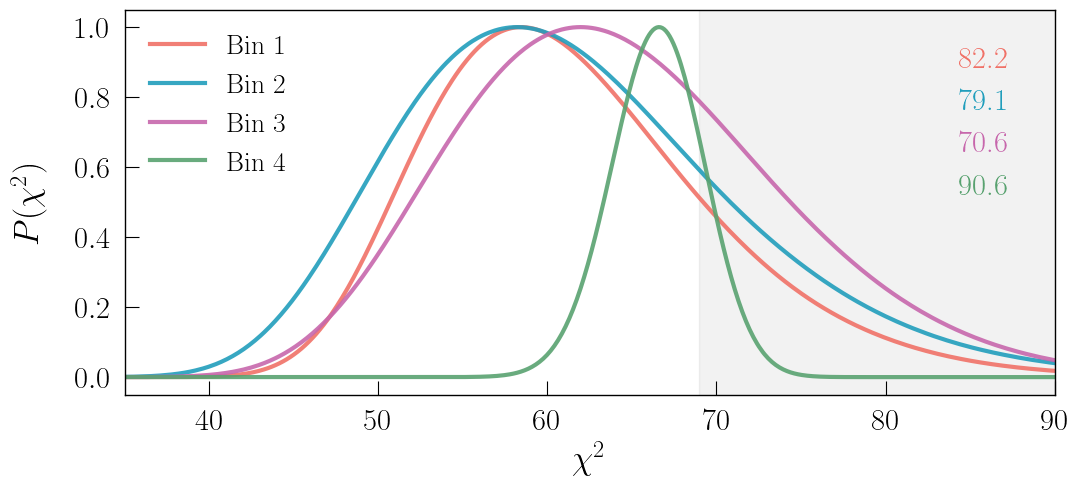

In [67]:
plt.figure(figsize = (12,5))
for i in range(4):
    
    X, bins = np.histogram(Likelihood[:, i, 1], bins = 1000, range = (30, 140))
    bins = (bins[1:] + bins[:-1])/2
    dX   = bins[1] - bins[0]
    X = gaussian_filter1d(X, 2/dX)
    X = X/np.max(X)
    plt.plot(bins, X, lw = 3, label = 'Bin %d' % (i + 1), color = 'C%d' % i, alpha = 0.9);
    avg  = np.average(Likelihood[:, i, 1] < stats.chi2(40).ppf(0.997))
    avg2 = np.average(Likelihood[:, i, 1] < stats.chi2(40).ppf(0.95))
    plt.text(0.95, 0.85 - 0.11*i, r'%0.1f' % (avg*100), fontsize = 22, color = 'C%d' % i, 
             transform = plt.gca().transAxes, ha = 'right')
plt.legend(fontsize = 20)

# plt.axvline(stats.chi2(40).ppf(0.997), color = 'k', lw = 2, ls = '--', zorder = -100)
plt.axvspan(stats.chi2(40).ppf(0.997), 90, color = 'k', alpha = 0.05)
plt.xlabel(r'$\chi^2$', size = 25)
plt.ylabel(r'$P(\chi^2)$', size = 25, labelpad = 20)

plt.xlim(35, 90)

plt.tick_params(which = 'both', pad = 10)
plt.savefig('./SOMPZ_WZ_chi2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [70]:
np.sum(good[:, :], axis = 0)

array([  838,  2124,    25, 13464])

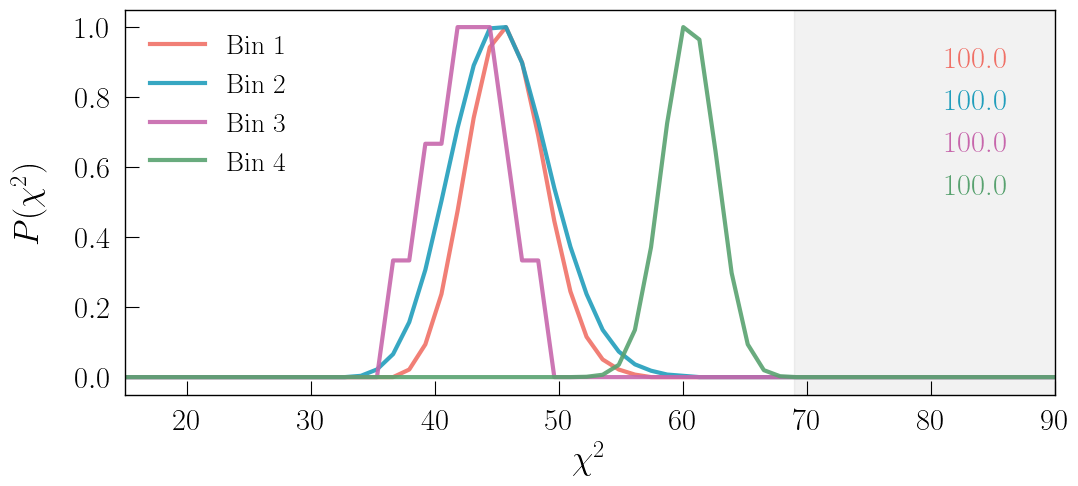

In [72]:
plt.figure(figsize = (12,5))
for i in range(4):
    
    X, bins = np.histogram(Likelihood[good[:, i], i, 1], bins = 100, range = (10, 140))
    bins = (bins[1:] + bins[:-1])/2
    dX   = bins[1] - bins[0]
    X = gaussian_filter1d(X, 2/dX)
    X = X/np.max(X)
    plt.plot(bins, X, lw = 3, label = 'Bin %d' % (i + 1), color = 'C%d' % i, alpha = 0.9);
    avg  = np.average(Likelihood[good[:, i], i, 1] < stats.chi2(40).ppf(0.997))
    avg2 = np.average(Likelihood[good[:, i], i, 1] < stats.chi2(40).ppf(0.95))
    plt.text(0.95, 0.85 - 0.11*i, r'%0.1f' % (avg*100), fontsize = 22, color = 'C%d' % i, 
             transform = plt.gca().transAxes, ha = 'right')
plt.legend(fontsize = 20)

# plt.axvline(stats.chi2(40).ppf(0.997), color = 'k', lw = 2, ls = '--', zorder = -100)
plt.axvspan(stats.chi2(40).ppf(0.997), 90, color = 'k', alpha = 0.05)
plt.xlabel(r'$\chi^2$', size = 25)
plt.ylabel(r'$P(\chi^2)$', size = 25, labelpad = 20)

plt.xlim(15, 90)

plt.tick_params(which = 'both', pad = 10)
# plt.savefig('./SOMPZ_WZ_chi2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()